In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ELU
from keras.layers import Lambda, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import ELU
from keras.optimizers import Adam
%matplotlib inline
# np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
model_name = 'keras'
batch_size = 20
epoch_num = 20
steps_per_epoch = 400

asset_path = '../train/assets'
train_name = f'model={model_name}-batch_size={batch_size}-num_epoch={epoch_num}-steps_per_epoch={steps_per_epoch}'
train_path = os.path.join(asset_path, train_name)

history_loc = os.path.join(train_path, 'history.p')
weights_loc = os.path.join(train_path, 'weights.h5')
tensorboard_loc = os.path.join(train_path, train_name)
print(history_loc, '\n', weights_loc, '\n', tensorboard_loc)

../train/assets/model=keras-batch_size=20-num_epoch=20-steps_per_epoch=400/history.p 
 ../train/assets/model=keras-batch_size=20-num_epoch=20-steps_per_epoch=400/weights.h5 
 ../train/assets/model=keras-batch_size=20-num_epoch=20-steps_per_epoch=400/model=keras-batch_size=20-num_epoch=20-steps_per_epoch=400


In [3]:
# Global Vars
img = (cv.imread('../train/photos/images/gray_Clipped/0.jpg')).shape
img_height = img[0]
img_width = img[1]
img_channels = img[2]
print(img, img_height, img_width, img_channels)

(136, 320, 3) 136 320 3


In [4]:
def adjust_Value(prvs_FRAME, curr_FRAME, HSV_value):
    prvs_FRAME = cv.cvtColor(prvs_FRAME, cv.COLOR_BGR2HSV)
    curr_FRAME = cv.cvtColor(curr_FRAME, cv.COLOR_BGR2HSV)
    prvs_FRAME[...,2] = prvs_FRAME[...,2]*HSV_value
    curr_FRAME[...,2] = curr_FRAME[...,2]*HSV_value
    return prvs_FRAME, curr_FRAME

In [5]:
def opticalFlow_DENSE(prvs_FRAME, curr_FRAME):
    # flow_mat = None
    # image_scale = 0.5
    # pyr_images = 1 # was 3
    # win_size = 15
    # pyr_iterations = 2 # was 3
    # poly_expans = 5
    # std = 1.3 # was 1.2
    
    flow_mat = None
    image_scale = 0.5
    pyr_images = 1 # was 3
    win_size = 10
    pyr_iterations = 2 # was 3
    poly_expans = 5
    std = 1.3 # was 1.2

    hsv = np.zeros_like(prvs_FRAME)
    hsv[...,1] = 255
    prvs_FRAME = cv.cvtColor(prvs_FRAME,cv.COLOR_BGR2GRAY)
    curr_FRAME = cv.cvtColor(curr_FRAME,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs_FRAME,curr_FRAME,flow_mat,image_scale,pyr_images,win_size,pyr_iterations,poly_expans,std,0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    return bgr

In [6]:
def getData(train_meta, kLoopCount, train_index):
    opt_flows = np.empty((0, img_height, img_width, img_channels), dtype='uint8')
    speed = np.empty((0))
    for k in range(kLoopCount):
        HSV_value = np.random.uniform(low=.7, high=1.4)
        curr_FRAME = cv.imread(train_meta['image_path'][train_index])
        #curr_FRAME = curr_FRAME[100:440, :-90]
        prvs_FRAME = cv.imread(train_meta['image_path'][train_index-1])
        #prvs_FRAME = prvs_FRAME[100:440, :-90]
        speed = np.append(speed, train_meta['speed'][train_index])
        prvs_FRAME, curr_FRAME = adjust_Value(prvs_FRAME, curr_FRAME, HSV_value)
        opt_flow = opticalFlow_DENSE(prvs_FRAME, curr_FRAME)
        opt_flow.dtype = 'uint8'
        opt_flows = np.append(opt_flows, [opt_flow], axis=0)
    return opt_flows, speed

In [7]:
def getTrainingData(train_meta, train_index, kLoopCount):
    global img_height, img_width, img_channels
    while True:
        opt_flow_arr = np.empty((0, img_height, img_width, img_channels))
        speed_arr = np.empty((0))
        for i in range(kLoopCount):
            index = np.random.randint(0, train_index.shape[0])
            opt_flow, speed = getData(train_meta, kLoopCount, train_index[index])
            opt_flow_arr = np.append(opt_flow_arr, opt_flow, axis=0)
            speed_arr = np.append(speed_arr, speed)
        yield opt_flow_arr, speed_arr

In [8]:
def getValData(train_meta, val_index, kLoopCount):
    while True:
        for i in range(len(val_index)):
            index = 0
            opt_flow, speed = getData(train_meta, kLoopCount, val_index[index])
            #opt_flow_arr = np.append(opt_flow_arr, opt_flow)
            yield opt_flow, speed

In [9]:
def createCNNModel():
    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=(5,5), strides=(3,3), activation='relu', input_shape=(136,320,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=20, kernel_size=(5,5), strides=(2,2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=15, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    #adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer='adam', loss='mse')
    return model

In [10]:
def start():
    global batch_size, epoch_num, steps_per_epoch, train_path
    train_csv_path = '../train/text/CSV'
    train_meta = pd.read_csv(os.path.join(train_csv_path, 'trainGrayClipped_meta.csv'))
    
    data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
    dataset_frames_num = train_meta.shape[0]
    train_frames_num = int(.8*(dataset_frames_num-1))
    
    train_index = data_index[:train_frames_num]
    val_index = data_index[train_frames_num:]
    print(train_index.shape, val_index.shape)
    
    #getTrainingData(train_meta, train_index, epoch_num)
    #getValData(train_meta, val_index, epoch_num)
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    
    valid_generator = getValData(train_meta, val_index, batch_size)
    val_size = len(val_index)
    earlyStopping = EarlyStopping(monitor='val_loss', 
                                  patience=1, 
                                  verbose=1, 
                                  min_delta = 0.23,
                                  mode='min',)
    
    modelCheckpoint = ModelCheckpoint(weights_loc, 
                                      monitor = 'val_loss', 
                                      save_best_only = True, 
                                      mode = 'min', 
                                      verbose = 1,
                                     save_weights_only = True)
    
    tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                                write_graph=True, write_images=True)
    callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]
    
    model = createCNNModel()
    
    train_size = len(train_index)
    train_generator = getTrainingData(train_meta, train_index, batch_size)
    history = model.fit_generator(
            train_generator, 
            steps_per_epoch = steps_per_epoch, 
            epochs = epoch_num,
            callbacks = callbacks_list,
            verbose = 1,
            validation_data = valid_generator,
            validation_steps = val_size)

    print(history)
    pickle.dump(history.history, open(history_loc, "wb"))
    
    return model, history.history, valid_generator, val_size

In [11]:
model, history, valid_generator, val_size = start()

(16319,) (4080,)
Epoch 1/20
400/400 [==============================] - 2664s 7s/step - loss: 28.0178 - val_loss: 7.7919

Epoch 00001: val_loss improved from inf to 7.79187, saving model to ../train/assets/model=keras-batch_size=20-num_epoch=20-steps_per_epoch=400/weights.h5
Epoch 2/20
400/400 [==============================] - 2564s 6s/step - loss: 15.5243 - val_loss: 5.2892

Epoch 00002: val_loss improved from 7.79187 to 5.28923, saving model to ../train/assets/model=keras-batch_size=20-num_epoch=20-steps_per_epoch=400/weights.h5
Epoch 3/20
400/400 [==============================] - 2556s 6s/step - loss: 11.3068 - val_loss: 2.2013

Epoch 00003: val_loss improved from 5.28923 to 2.20130, saving model to ../train/assets/model=keras-batch_size=20-num_epoch=20-steps_per_epoch=400/weights.h5
Epoch 4/20
400/400 [==============================] - 2549s 6s/step - loss: 12.2778 - val_loss: 1.8348

Epoch 00004: val_loss improved from 2.20130 to 1.83484, saving model to ../train/assets/model=ker

In [ ]:
history = pickle.load(open(history_loc, "rb" ))
model.load_weights(weights_loc)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [ ]:
val_score = model.evaluate_generator(valid_generator, steps=val_size)
print('val score:', val_score)

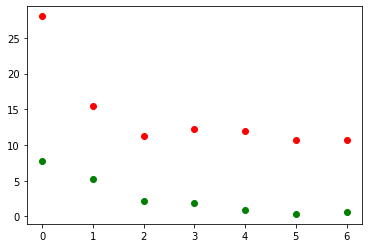

In [12]:
plt.plot(history['loss'], 'ro')
plt.plot(history['val_loss'], 'go')

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size
fig_size2 = plt.rcParams["figure.figsize"]
print(fig_size2)

In [ ]:
train_csv_path = '../train/text/CSV'
train_meta = pd.read_csv(os.path.join(train_csv_path, 'trainGrayClipped_meta.csv'))

data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
dataset_frames_num = train_meta.shape[0]
train_frames_num = int(.8*(dataset_frames_num-1))

train_index = data_index[:train_frames_num]
val_index = data_index[train_frames_num:]
print(train_index, val_index)
plt.plot(train_meta['speed'][train_index], 'ro')
plt.plot(train_meta['speed'][val_index], 'go')